# Seattle Car Crash Severity Prediction

IBM Coursera Applied Data Science Capstone Project.

Yohanes A Crux Gosal <br>
04 October 2020

### Table of Contents

 - Introduction
 - Data
 - Models
 - Evaluation
 

In [1]:
# Basic libraries that are used in this notebook, any other libraries are imported later.
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
%matplotlib inline

print('Libraries successfully imported.')
print('matplotlib version: ', matplotlib.__version__)
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('seaborn version: ', sns.__version__)
print('scikit-learn version: ', sklearn.__version__)

Libraries successfully imported.
matplotlib version:  3.0.2
numpy version:  1.15.4
pandas version:  0.24.1
seaborn version:  0.9.0
scikit-learn version:  0.20.3


## Introduction

Car crashes are one of the most common accidents that could cause severe injuries and even death. If somehow we can predict when or where a severe car collisions will happen, based on previous data, then the local government (Seattle government) might be able to take preventive measures. This would help in reducing number of car crashes and severity of the collisions. Some common causes of car accidents are poor lighting, bad weather, and bad road condition. Speeding and driving under the influence of alcohol or drugs will also likely lead to crashes. But, we will not know whether the driver was speeding or drunk prior to the crashes. So, those information will not help us in predicting whether a car crash is severe or not.

## Data


To answer the problem given in previous section, we will use data provided by Seattle Department of Transportation. The most recent dataset can be accessed on [Seattle GeoData](https://data-seattlecitygis.opendata.arcgis.com/datasets/collisions) website. While, the the dataset used in this notebook is downloaded on September 2020. This dataset holds various information regarding the car crash, but we will only use some features, like road condition and light condition, that can be known prior to the crash.

In [2]:
# The code was removed by Watson Studio for sharing.

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.356511,47.517361,1,327920,329420,3856094,Matched,Intersection,34911.0,17TH AVE SW AND SW ROXBURY ST,,NaN,1,Property Damage Only Collision,Angles,2,0,0,2,0,0,0,2020/01/19 00:00:00+00,1/19/2020 9:01:00 AM,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.361405,47.702064,2,46200,46200,1791736,Matched,Block,NaN,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,NaN,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,0,0,0,2005/04/11 00:00:00+00,4/11/2005 6:31:00 PM,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",Y,0,Raining,Wet,Dusk,NaN,5101020.0,NaN,13,From same direction - both going straight - bo...,0,0,N
2,-122.317414,47.664028,3,1212,1212,3507861,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,,NaN,2,Injury Collision,Head On,2,0,0,2,1,0,0,2013/03/31 00:00:00+00,3/31/2013 2:09:00 AM,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,30,From opposite direction - all others,0,0,N
3,-122.318234,47.619927,4,327909,329409,EA03026,Matched,Intersection,29054.0,11TH AVE E AND E JOHN ST,,NaN,2,Injury Collision,Pedestrian,3,1,0,1,1,0,0,2020/01/06 00:00:00+00,1/6/2020 5:55:00 PM,At Intersection (intersection related),24.0,MOTOR VEHCILE STRUCK PEDESTRIAN,NaN,N,Raining,Wet,Dark - Street Lights On,NaN,NaN,NaN,0,Vehicle going straight hits pedestrian,0,0,N
4,-122.351724,47.560306,5,104900,104900,2671936,Matched,Block,NaN,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,NaN,NaN,2,Injury Collision,Other,2,0,0,1,1,0,0,2009/12/25 00:00:00+00,12/25/2009 7:00:00 PM,Mid-Block (not related to intersection),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,0,Clear,Ice,Dark - Street Lights On,NaN,9359012.0,Y,50,Fixed object,0,0,N


We will use ADDRTYPE, WEATHER, ROADCOND, and LIGHTCOND attributes to help predict whether a collision is severe or not. Information in these attributes should be known prior to the collision. For example, if the weather is raining and the road condition is wet, then a crash will likely to happen.

In [3]:
collisions_df = df_data[['ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEVERITYCODE']]
collisions_df.head()

,ADDRTYPE,WEATHER,ROADCOND,LIGHTCOND,SEVERITYCODE
0,Intersection,Clear,Dry,Daylight,1
1,Block,Raining,Wet,Dusk,1
2,Block,Clear,Dry,Dark - Street Lights On,2
3,Intersection,Raining,Wet,Dark - Street Lights On,2
4,Block,Clear,Ice,Dark - Street Lights On,2


In [4]:
print("Dataset size: ", collisions_df.shape)

Dataset size:  (221738, 5)


Now, we split the dataset into train and test set.

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(collisions_df, test_size=0.2, random_state=0)

print("Training set size: ", train_set.shape)
print("Test set size: ", test_set.shape)

Training set size:  (177390, 5)
Test set size:  (44348, 5)


Now, we will explore and preprocess the training set.

In [6]:
# check for null values
print("Missing values in training set: ")
train_set.isnull().sum()

Missing values in training set: 


ADDRTYPE         2949
WEATHER         21220
ROADCOND        21153
LIGHTCOND       21292
SEVERITYCODE        1
dtype: int64

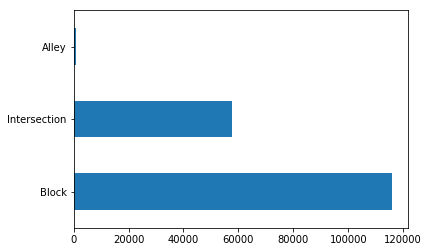

In [7]:
train_set.ADDRTYPE.value_counts().plot(kind='barh')

Because there is only a small number of missing values in the ADDRTYPE and SEVERITYCODE columns, we will drop those rows with missing address type or severity code.

In [8]:
train_set.dropna(axis=0, subset=['ADDRTYPE', 'SEVERITYCODE'], inplace=True)
train_set.isnull().sum()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


ADDRTYPE            0
WEATHER         19712
ROADCOND        19646
LIGHTCOND       19784
SEVERITYCODE        0
dtype: int64

Address type and severity relationship

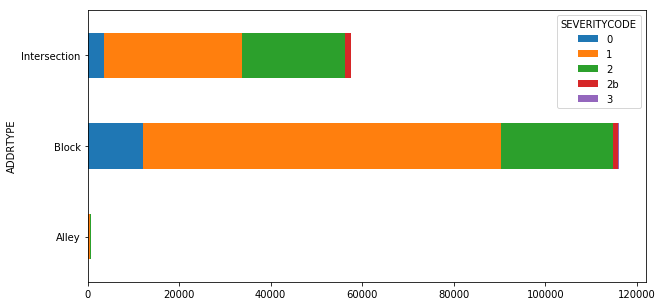

In [35]:
data = pd.pivot_table(train_set[['ADDRTYPE', 'SEVERITYCODE']], index='ADDRTYPE', columns='SEVERITYCODE', aggfunc=len)
data.plot(kind='barh', stacked=True, figsize=(10, 5))

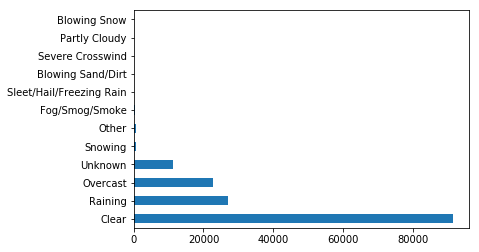

In [10]:
train_set.WEATHER.value_counts().plot.barh()

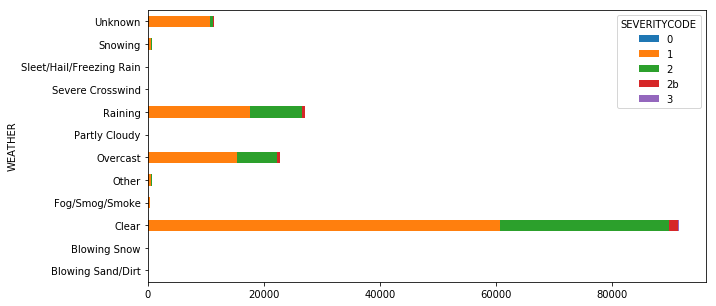

In [41]:
data = pd.pivot_table(train_set[['WEATHER', 'SEVERITYCODE']], index='WEATHER', columns='SEVERITYCODE', aggfunc=len)
data.plot(kind='barh', stacked=True, figsize=(10, 5))

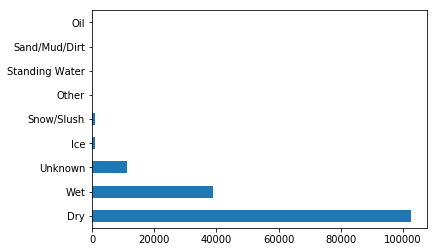

In [11]:
train_set.ROADCOND.value_counts().plot.barh()

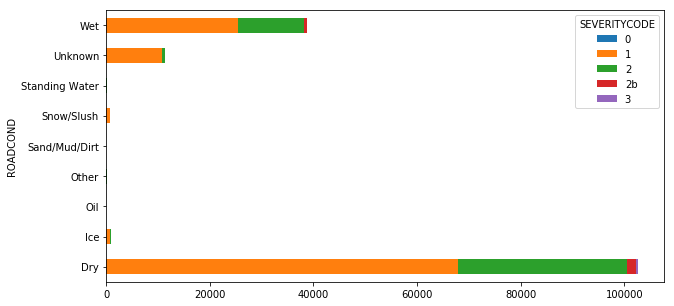

In [42]:
data = pd.pivot_table(train_set[['ROADCOND', 'SEVERITYCODE']], index='ROADCOND', columns='SEVERITYCODE', aggfunc=len)
data.plot(kind='barh', stacked=True, figsize=(10, 5))

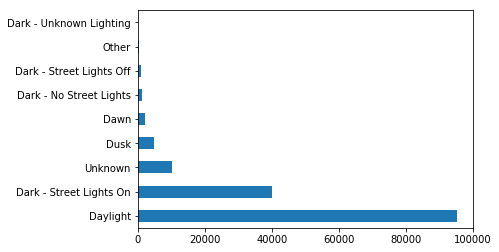

In [12]:
train_set.LIGHTCOND.value_counts().plot.barh()

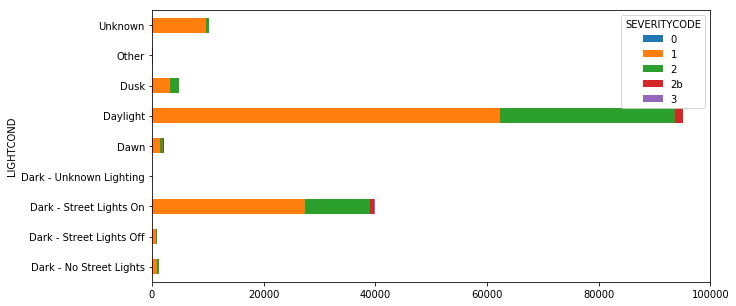

In [48]:
data = pd.pivot_table(train_set[['LIGHTCOND', 'SEVERITYCODE']], index='LIGHTCOND', columns='SEVERITYCODE', aggfunc=len)

data.plot(kind='barh', stacked=True, figsize=(10, 5))

Based on the above bar plots, we can see that there are "Unknown" values in the WEATHER, ROADCOND, and LIGHTCOND columns. So, we will put the missing values in the "Unknown" category.

In [49]:
train_set.fillna(value='Unknown', inplace=True)
train_set.isnull().sum()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


ADDRTYPE        0
WEATHER         0
ROADCOND        0
LIGHTCOND       0
SEVERITYCODE    0
dtype: int64

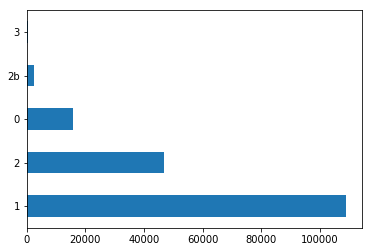

In [50]:
train_set.SEVERITYCODE.value_counts().plot.barh()

Based on the metadata, the description for each code are:
 - 0 -- unknown
 - 1 -- property damage
 - 2 -- injury
 - 2b -- serious injury
 - 3 -- fatality
 
We will ignore data with severity code of 0, because that will not give us any information regarding the severity of the crash. Then, we are going to put category 2, 2b and 3 into one category. Now we have two classes, 0 for no injury (not severe crash) and 1 for severe crash (there are injuries).

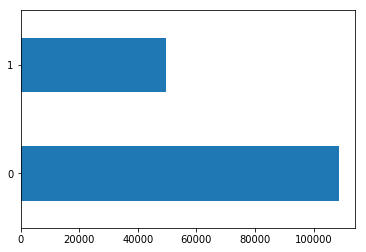

In [51]:
train_set = train_set[train_set.SEVERITYCODE != '0']
train_set.SEVERITYCODE = train_set.SEVERITYCODE.replace(to_replace=['1', '2', '2b', '3'], 
                                                                value=[0, 1, 1, 1])
train_set.SEVERITYCODE.value_counts().plot.barh()

After regrouping the classes, we still have imbalanced distribution between the 0 and 1 class. We will use Synthetic Minority Oversampling Technique (SMOTE) to address the imbalance problem.

In [1]:
!conda install -c conda-forge imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

print("SMOTE successfully imported, imblearn version: ", imblearn.__version__)

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    imbalanced-learn-0.7.0     |             py_1          97 KB  conda-forge
    joblib-0.17.0              |             py_0         204 KB  conda-forge
    scikit-learn-0.23.2        |   py36h0573a6f_0         6.9 MB
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    threadpoolctl-2.1.0        |     pyh5ca1d4c_0          15 KB  conda-forge
    ------------------------------------------------------------
                                

In [52]:
X = train_set.drop(['SEVERITYCODE'], axis=1)
y = train_set.SEVERITYCODE

Because all of our features are categorical, we need to transform the data with one-hot encoding. 

In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

oh_enc = OneHotEncoder(handle_unknown='ignore')
X = oh_enc.fit_transform(X)

In [29]:
sm = SMOTE(sampling_strategy=0.7, random_state=42)
X_res, y_res = sm.fit_resample(X, y)

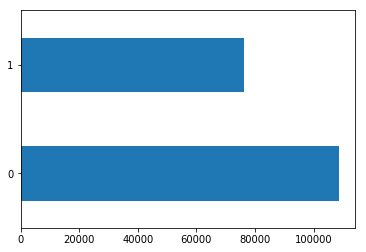

In [30]:
y_res.value_counts().plot.barh()

## Models

We are going to use several machine learning models to predict the severity of the crash. We are going to use Decision Tree, Random Forest, AdaBoost, KNN, and SVM. For selecting best model, we will evaluate the model performance on validation set. 

In [24]:
# split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
print('Train set size: ', X_train.shape)
print('Validation set size: ', X_val.shape)

Train set size:  (126889, 33)
Validation set size:  (31723, 33)


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_val)

val_acc = accuracy_score(y_val, preds)
print("Validation accuracy: ", val_acc)
print(classification_report(y_val, preds, target_names=["Not Severe", "Severe"]))

Validation accuracy:  0.6815559688554046
              precision    recall  f1-score   support

  Not Severe       0.68      1.00      0.81     21656
      Severe       0.39      0.01      0.01     10067

    accuracy                           0.68     31723
   macro avg       0.54      0.50      0.41     31723
weighted avg       0.59      0.68      0.56     31723



In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score


X_trainres, X_valres, y_trainres, y_valres = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

clf = DecisionTreeClassifier()
clf.fit(X_trainres, y_trainres)
preds = clf.predict(X_valres)

val_acc = accuracy_score(y_valres, preds)
print("Validation accuracy: ", val_acc)
print(classification_report(y_valres, preds, target_names=["Not Severe", "Severe"]))

Validation accuracy:  0.6292523440244265
              precision    recall  f1-score   support

  Not Severe       0.66      0.75      0.70     21679
      Severe       0.56      0.46      0.51     15330

    accuracy                           0.63     37009
   macro avg       0.61      0.61      0.61     37009
weighted avg       0.62      0.63      0.62     37009



Based on the above classification reports, we could see that the prediction on the original dataset is biased to the Not Severe class. After using SMOTE, the prediction on the minority class is better although the overall accuracy dropped. It is more important to predict the Severe class correctly than the Not Severe class. Thus, we are going to use the resampled dataset.

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_trainres, y_trainres)
preds = clf.predict(X_valres)

val_acc = accuracy_score(y_valres, preds)
print("Validation accuracy: ", val_acc)
print(classification_report(y_valres, preds, target_names=["Not Severe", "Severe"]))

Validation accuracy:  0.6293063849333945
              precision    recall  f1-score   support

  Not Severe       0.66      0.75      0.70     21679
      Severe       0.56      0.46      0.51     15330

    accuracy                           0.63     37009
   macro avg       0.61      0.61      0.61     37009
weighted avg       0.62      0.63      0.62     37009



In [33]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X_trainres, y_trainres)

preds = clf.predict(X_valres)
val_acc = accuracy_score(y_valres, preds)
print("Validation accuracy: ", val_acc)
print(classification_report(y_valres, preds, target_names=["Not Severe", "Severe"]))

Validation accuracy:  0.6287659758437137
              precision    recall  f1-score   support

  Not Severe       0.66      0.75      0.70     21679
      Severe       0.56      0.46      0.50     15330

    accuracy                           0.63     37009
   macro avg       0.61      0.60      0.60     37009
weighted avg       0.62      0.63      0.62     37009



In [34]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_trainres, y_trainres)
preds = clf.predict(X_valres)

val_acc = accuracy_score(y_valres, preds)
print("Validation accuracy: ", val_acc)
print(classification_report(y_valres, preds, target_names=["Not Severe", "Severe"]))

Validation accuracy:  0.5478937555729687
              precision    recall  f1-score   support

  Not Severe       0.59      0.72      0.65     21679
      Severe       0.44      0.31      0.36     15330

    accuracy                           0.55     37009
   macro avg       0.51      0.51      0.51     37009
weighted avg       0.53      0.55      0.53     37009



In [35]:
from sklearn.svm import SVC

clf = SVC(kernel='poly', degree=3, C=1, gamma='scale')
clf.fit(X_trainres, y_trainres)

preds = clf.predict(X_valres)
val_acc = accuracy_score(y_valres, preds)
print("Validation accuracy: ", val_acc)
print(classification_report(y_valres, preds, target_names=["Not Severe", "Severe"]))

Validation accuracy:  0.6289280985706179
              precision    recall  f1-score   support

  Not Severe       0.66      0.75      0.70     21679
      Severe       0.56      0.46      0.51     15330

    accuracy                           0.63     37009
   macro avg       0.61      0.60      0.61     37009
weighted avg       0.62      0.63      0.62     37009



Since all the models have similar accuracy, we decided to go with RandomForest because it has the highest accuracy of all models used. Next, we are going to do hyperparameter tuning for RandomForest model.

In [36]:
from sklearn.model_selection import GridSearchCV


param_grid = {"n_estimators": [i for i in range(40, 61)]}
clf = RandomForestClassifier(random_state=0)
grid_clf = GridSearchCV(clf, param_grid=param_grid, scoring='roc_auc')
grid_clf.fit(X_res, y_res)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'n_estimators': [40, 41, 42, 43, 44, 45, 46, 47, 48,
                                          49, 50, 51, 52, 53, 54, 55, 56, 57,
                                          58, 59, 60]},
             scoring='roc_auc')

In [38]:
grid_clf.best_params_

{'n_estimators': 55}

## Evaluation

From the last section, we found out that AdaBoostClassifier with 60 estimators is the best model. Now, we will re-train the model using the entire train set to predict the test set.

In [39]:
test_set.isnull().sum()

ADDRTYPE         765
WEATHER         5421
ROADCOND        5407
LIGHTCOND       5438
SEVERITYCODE       0
dtype: int64

In [40]:
test_set.dropna(axis=0, subset=['ADDRTYPE', 'SEVERITYCODE'], inplace=True)
test_set.fillna('Unknown', inplace=True)
test_set.isnull().sum()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


ADDRTYPE        0
WEATHER         0
ROADCOND        0
LIGHTCOND       0
SEVERITYCODE    0
dtype: int64

In [41]:
test_set = test_set[test_set.SEVERITYCODE != '0']
test_set.SEVERITYCODE = test_set.SEVERITYCODE.replace(to_replace=['1', '2', '2b', '3'], 
                                                                value=[0, 1, 1, 1])

In [42]:
X_test = test_set.drop(['SEVERITYCODE'], axis=1)
y_test = test_set['SEVERITYCODE']

X_test = oh_enc.transform(X_test)

In [46]:
clf = grid_clf.best_estimator_
clf.fit(X_res, y_res)

preds = clf.predict(X_test)

In [48]:
print("Test accuracy: ", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Test accuracy:  0.6544668150546338
              precision    recall  f1-score   support

           0       0.75      0.74      0.75     27188
           1       0.45      0.46      0.45     12348

    accuracy                           0.65     39536
   macro avg       0.60      0.60      0.60     39536
weighted avg       0.66      0.65      0.66     39536

